# Prognóstico do Câncer do Colo Uterino
Implementação e Avaliação de Modelos Preditivos

## Módulos

Área reservada para instalação de Módulos não disponíveis originalmente no ambiente Python em execução. O ambiente escolhido para o desenvolvimento deste projeto foi o Google Colab. Portanto, caso haja interesse em executar esse Notebook Jupyter, é necessário hospedar a pasta completa do projeto no Google Drive e realizar a alteração do valor da variável "dir_padrao" na etapa "diretorio" da Pipeline "pipAmbiente" da Seção "Preparação" deste projeto.

In [ ]:
!pip install category_encoders

## Bibliotecas

Lista das Bibliotecas utilizadas para a devida execução do Projeto.

1. **Pipeline**: tanto para o Preparação, quanto para o Treinamento, foi utilizada a estratégia de sequenciar os passo em fluxos de códigos organizados em Pipelines. Especificamente para o treinamento, foi utilizada a "imblearn.pipeline" a possibilitar o balancemento do conjunto de dados considerando a variável alvo: Resultado do Exame de Biópsia;

2. **Básicos**: bibliotecas gerais;

3. **Preparação**: bibliotecas responsáveis por preparar os dados originais para realizar o treinamento dos modelos candidatos;

4. **Grid Search**: bibliotecas responsáveis pela otimização e ajuste dos hiperparâmetro dos modelos candidatos;

5. **Classificadores**: Classificadores escolhidos como candidatos a melhor modelos após treinamento e validação;

6. **Avaliação**: Bibliotecas para geração e exibição das métricas utilizadas para avaliar e definir o modelo final.

7. **Notebook**: ajustes do notebook para melhor apresentação do código e gráficos.


In [ ]:
#Pipeline
from sklearn.pipeline import Pipeline as pip_skl
from imblearn.pipeline import Pipeline as pip_imb

#Básicos
from google.colab import drive
from os import getcwd, listdir, chdir
import json
import requests
import pandas as pd
import numpy as np
from collections import Counter
import pprint
import warnings
from joblib import dump, load
from shutil import copyfile

#Preparação
import sklearn
from sklearn.model_selection import train_test_split
from yellowbrick.target import ClassBalance
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#Grid Search
from sklearn.model_selection import GridSearchCV

#Classificadores
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

#Avaliação
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

#Notebook
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

## Preparação

Geração da Pipeline de preparação do ambiente e dos dados para treinamento.
1. Montagem do Google Drive;
2. Definição do diretório padrão;
3. Extração dos dados originais;
4. Organização das colunas (*features*) do conjunto de dados (*dataset*).

In [ ]:
def montarGoogleDrive():
  drive.mount('/content/drive')

In [ ]:
def mudarDiretorioPadrao():
  dir_padrao = 'drive/My Drive/04 Pós IAAM/06 PAM2 - Projeto Integrado em Aprendizagem de Máquina/05 Desenvolvimento/02 Projeto/'
  chdir(dir_padrao)

In [ ]:
pipAmbiente = pip_skl([
    ('drive', montarGoogleDrive()),
    ('diretorio', mudarDiretorioPadrao())
])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def recuperarDadosOriginais():
  configuracao_global_caminho = 'configuracao/configuracao_global.json'
  configuracao_global = json.loads(open(configuracao_global_caminho).read())

  url_dados = configuracao_global['URL']['url_dados']
  dir_dados = configuracao_global['ARQUIVO']['dir_dados']

  arquivo_original = url_dados.rsplit('/', 1)[1]
  r = requests.get(url_dados, allow_redirects=True)
  open(dir_dados + arquivo_original, 'wb').write(r.content)

  configuracao_global['ARQUIVO']['arquivo_original'] = arquivo_original

  with open(configuracao_global_caminho, 'w', encoding='utf8') as arquivo:
    json.dump(configuracao_global, arquivo, ensure_ascii=False, sort_keys=True, indent=4)

In [ ]:
def organizarColunas():
  configuracao_global_caminho = 'configuracao/configuracao_global.json'
  configuracao_global = json.loads(open(configuracao_global_caminho).read())

  arquivo_dados_colunas_caminho = 'configuracao/arquivo_dados_colunas.json'
  arquivo_dados_colunas = json.loads(open(arquivo_dados_colunas_caminho).read())

  arquivo_original = configuracao_global['ARQUIVO']['dir_dados'] + configuracao_global['ARQUIVO']['arquivo_original']
  df = pd.read_csv(arquivo_original, na_values='?')

  df.dropna(how='all', inplace=True)

  df.columns = list(arquivo_dados_colunas.keys())
  df = df.astype(arquivo_dados_colunas)
  
  df.to_csv(configuracao_global['ARQUIVO']['dir_dados'] + configuracao_global['ARQUIVO']['arquivo_dados'], index=False, header=True, sep=';', decimal=',')

In [ ]:
pipDados = pip_skl([
    ('download', recuperarDadosOriginais()),
    ('colunas', organizarColunas())
])

In [ ]:
pipPreparacao = pip_skl([
    ('ambiente', pipAmbiente),
    ('dados', pipDados)])

## Treinamento

Etapa de definição dos dados de treinamento e teste e configuração da Pipeline de ajustes dos modelos candidatos. Aqui, inicia efetivamente os passos relacionados modelagem e geral do produto: Modelo de Predição do Câncer do Colo uterino.

In [ ]:
configuracao_global_caminho = 'configuracao/configuracao_global.json'
configuracao_global = json.loads(open(configuracao_global_caminho).read())

arquivo_dados = configuracao_global['ARQUIVO']['dir_dados'] + configuracao_global['ARQUIVO']['arquivo_dados']
df = pd.read_csv(arquivo_dados, sep=';', decimal=',')

X = df.drop('y_biopsia', axis=1, inplace=False)
y = df['y_biopsia']

Definidos 33% do conjunto de dados para teste do modelo.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

As classes alvo estão muito desbalaceadas. Na Pipeline de ajuste do Modelo, será aplicada a técnica SMOTE para o balanceamento das classes com o objetivo de garantir um modelo capaz de predizer igualmente as classes acerca do exame "Biópsia":

**0 - Resultado Negativo**

**1 - Resultado Positivo**

Conjunto de dados completo: 858 instâncias.

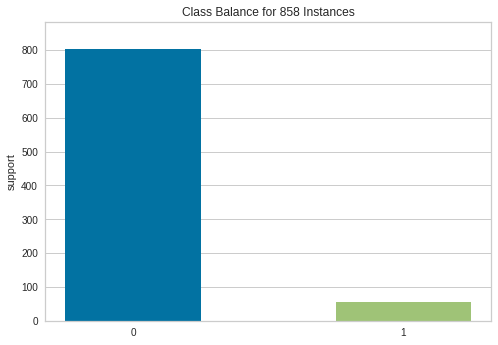

In [ ]:
viz = ClassBalance()
viz.fit(y)
viz.poof()

Base de Treino: 574 instâncias (67%).

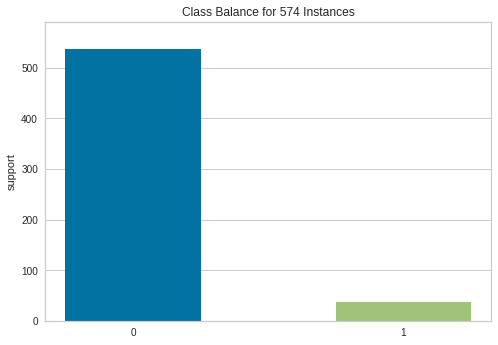

In [ ]:
viz = ClassBalance()
viz.fit(y_train)
viz.poof()

Base de Teste: 284 instâncias (33%).

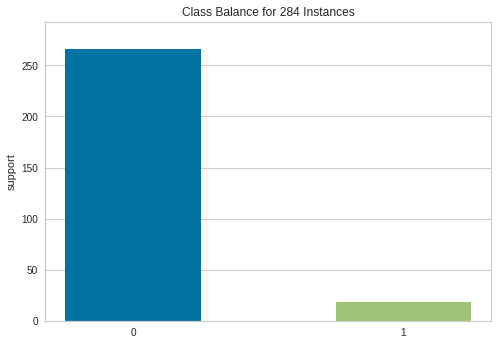

In [ ]:
viz = ClassBalance()
viz.fit(y_test)
viz.poof()

Listagem de colunas (*features*)

In [ ]:
df_colunas = df.dtypes.to_frame('dtypes').reset_index()
df_colunas.columns = ['coluna', 'tipo']
df_colunas

,coluna,tipo
0,idade_paciente_anos,float64
1,parceiros_sexuais_numero,float64
2,primeira_relacao_sexual_idade,float64
3,gestacoes_numero,float64
4,fuma,bool
5,fuma_anos,float64
6,fuma_macos_ano,float64
7,contraceptivos_hormonais,bool
8,contraceptivos_hormonais_anos,float64
9,diu,bool


Listagem das colunas que possuem dados nulos e respectivos tipos.

In [ ]:
colunas_na = list(df.columns[df.isna().any()])
colunas_na

['parceiros_sexuais_numero',
 'primeira_relacao_sexual_idade',
 'gestacoes_numero',
 'fuma_anos',
 'fuma_macos_ano',
 'contraceptivos_hormonais_anos',
 'diu_anos',
 'dsts_numero',
 'dsts_primeiro_diagnostico_anos',
 'dsts_ultimo_diagnostico_anos']

In [ ]:
df_colunas[df_colunas.coluna.isin(colunas_na)]

,coluna,tipo
1,parceiros_sexuais_numero,float64
2,primeira_relacao_sexual_idade,float64
3,gestacoes_numero,float64
5,fuma_anos,float64
6,fuma_macos_ano,float64
8,contraceptivos_hormonais_anos,float64
10,diu_anos,float64
12,dsts_numero,float64
26,dsts_primeiro_diagnostico_anos,float64
27,dsts_ultimo_diagnostico_anos,float64


Separação das colunas que receberão a respectiva **Mediana** ou **Valor Mais Frequente** na ocorrência de dados ausentes.

In [ ]:
colunas_na_mediana = []
colunas_na_frequente = []
colunas_na_outros = []

for i in df_colunas.index:
  coluna = df_colunas.at[i, 'coluna']
  tipo = df_colunas.at[i, 'tipo']

  if coluna in colunas_na:
    if tipo in ['float64']:
      colunas_na_mediana.append(coluna)
    elif tipo in ['bool']:
      colunas_na_frequente.append(coluna)
    else:
      colunas_na_outros.append(coluna)

print('colunas_na_mediana:', colunas_na_mediana)
print('colunas_na_frequente:', colunas_na_frequente)
print('colunas_na_outros:', colunas_na_outros)

colunas_na_mediana: ['parceiros_sexuais_numero', 'primeira_relacao_sexual_idade', 'gestacoes_numero', 'fuma_anos', 'fuma_macos_ano', 'contraceptivos_hormonais_anos', 'diu_anos', 'dsts_numero', 'dsts_primeiro_diagnostico_anos', 'dsts_ultimo_diagnostico_anos']
colunas_na_frequente: []
colunas_na_outros: []


Definição das Pipelines que serão etapas de transformação dos dados das colunas (ColumnTransformer):

1. SimpleImputer para estratégia de Mediana;
2. SimpleImputer para estratégia de Mais Frequente;

In [ ]:
pipMediana = pip_imb([
    ('mediana', SimpleImputer(strategy='median'))
])

In [ ]:
pipFrequente = pip_imb([
    ('frequente', SimpleImputer(strategy='most_frequent'))
])

In [ ]:
columnTransformer = ColumnTransformer(transformers=[
    ('mediana', pipMediana, colunas_na_mediana),
    ('frequent', pipFrequente, colunas_na_frequente)
])

Listagem dos Estimadores candidatos a melhor modelo de classificação após ajuste e validação. O dicionário abaixo é composto pelo nome do estimador, o objeto correspondente e a listagem de valores de hiperparâmetros para a busca do melhor ajuste realizado pelo Grid Search.

In [ ]:
estimadores = {
  'AdaBoostClassifier': {
    'estimador': AdaBoostClassifier(),
    'parametros': {
      'estimador__random_state': [
        1,
        2
      ],
      'estimador__learning_rate': [
        0.01
      ],
      'estimador__n_estimators': [
        150
      ]
    }
  },
  'GradientBoostingClassifier': {
    'estimador': GradientBoostingClassifier(),
    'parametros': {
      'estimador__random_state': [
        1
      ],
      'estimador__learning_rate': [
        0.01
      ],
      'estimador__n_estimators': [
        100
      ],
      'estimador__max_depth': [
        3
      ],
      'estimador__min_samples_split': [
        2
      ],
      'estimador__min_samples_leaf': [
        2
      ]
    }
  },
  'RandomForestClassifier': {
    'estimador': RandomForestClassifier(),
    'parametros': {
      'estimador__random_state': [
        1
      ],
      'estimador__n_jobs': [
        -1,
        2,
        4
      ],
      'estimador__n_estimators': [
        10,
        100
      ],
      'estimador__criterion': [
        'gini'
      ],
      'estimador__min_samples_split': [
        2,
        3
      ],
      'estimador__min_samples_leaf': [
        1,
        2,
        3,
        4,
        5
      ]
    }
  },
  'KNeighborsClassifier': {
    'estimador': KNeighborsClassifier(),
    'parametros': {
      'estimador__n_neighbors': [
        2,
        3,
        4,
        5,
        6
      ],
      'estimador__n_jobs': [
        -1
      ],
      'estimador__weights': [
        'distance'
      ],
      'estimador__leaf_size': [
        15
      ]
    }
  },
  'SVC': {
    'estimador': SVC(),
    'parametros': {
      'estimador__random_state': [
        1
      ],
      'estimador__probability': [
        True
      ],
      'estimador__C': [
        100
      ],
      'estimador__tol': [
        0.005
      ],
      'estimador__kernel': [
        'sigmoid'
      ]
    }
  },
  'LogisticRegression': {
    'estimador': LogisticRegression(),
    'parametros': {
      'estimador__solver': [
        'newton-cg'
      ],
      'estimador__multi_class': [
        'multinomial'
      ],
      'estimador__C': [
        2000
      ],
      'estimador__tol': [
        0.0001
      ]
    }
  },
    'XGBClassifier': {
    'estimador': XGBClassifier(),
    'parametros': {
      'estimador__learning_rate': [
        0.1
      ],
      'estimador__n_estimators': [
        10,
        100,
        1000
      ],
      'estimador__max_depth': [
        5,
        10,
        100
      ],
      'estimador__min_child_weight': [
        1
      ],
      'estimador__gamma': [
        0
      ],
      'estimador__subsample': [
        0.8
      ],
      'estimador__colsample_bytree': [
        0.8
      ],
      'estimador__objective': [
        'binary:logistic'
      ],
      'estimador__nthread': [
        4
      ],
      'estimador__scale_pos_weight': [
        1
      ],
      'estimador__seed': [
        27
      ]
    }
  }
}

Verificação dos scores disponíveis para avaliação do treinamento dos modelos.

A partir desta lista, foi escolhido e definido no arquivo de configuração global a métrica **f1_weighted** por ser uma média ponderada de outras duas métricas muito importantes neste contexto: a **Precisão** (*Precison*) e a **Revocação** (*Recall*).

In [ ]:
pprint.pprint(sklearn.metrics.SCORERS)

{'accuracy': make_scorer(accuracy_score),
 'adjusted_mutual_info_score': make_scorer(adjusted_mutual_info_score),
 'adjusted_rand_score': make_scorer(adjusted_rand_score),
 'average_precision': make_scorer(average_precision_score, needs_threshold=True),
 'balanced_accuracy': make_scorer(balanced_accuracy_score),
 'completeness_score': make_scorer(completeness_score),
 'explained_variance': make_scorer(explained_variance_score),
 'f1': make_scorer(f1_score, average=binary),
 'f1_macro': make_scorer(f1_score, pos_label=None, average=macro),
 'f1_micro': make_scorer(f1_score, pos_label=None, average=micro),
 'f1_samples': make_scorer(f1_score, pos_label=None, average=samples),
 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted),
 'fowlkes_mallows_score': make_scorer(fowlkes_mallows_score),
 'homogeneity_score': make_scorer(homogeneity_score),
 'jaccard': make_scorer(jaccard_score, average=binary),
 'jaccard_macro': make_scorer(jaccard_score, pos_label=None, average=mac

Recuperação de dois parâmetros definidos no arquivo de configuração global do projeto: a métrica que será utilizada na avaliação da Validação Cruzada (*Cross Validation*) - o parâmetro "**scoring**" - e a quantidade de *folds* desta validação - o parâmetro "**cv**".

In [ ]:
gridsearchcv_scoring = configuracao_global['TREINAMENTO']['gridsearchcv_scoring']
gridsearchcv_cv = configuracao_global['TREINAMENTO']['gridsearchcv_cv']

print('gridsearchcv_scoring:', gridsearchcv_scoring)
print('gridsearchcv_cv:', gridsearchcv_cv)

gridsearchcv_scoring: f1_weighted
gridsearchcv_cv: 10


Para cada estimador definido anteriormente, é executado a pesquisa em todos os valores de parâmetros especificados para este estimador. Mas para isso, são executados os passos abaixo:

1. **columnTransformer**: substituição dos valores ausentes conforme pipeline exlusiva;
2. **ohe**: aplicação do algorítimo "OneHotEncoder" para transformar colunas categóricas em colunas boleanas;
3. **standardscaler**: padronização do valores das colunas a partir da média e o desvio padrão no conjunto de treinamento, de modo a poder reaplicar, posteriormente, a mesma transformação no conjunto de teste;
4. **balanceamento**: aplicação da técnica SMOTE para equalizar a quantidade de classes alvo.
5. **estimador**: modelo que será ajustado e avaliado durante o treinamento.

In [ ]:
%%time

resultados = {}

for nomeEstimador in estimadores:
  pipTreinamento = pip_imb([
    ('columnTransformer', columnTransformer),
    ('ohe', OneHotEncoder()),
    ('standardscaler', StandardScaler()),
    ('balanceamento', SMOTE()),
    ('estimador', estimadores[nomeEstimador]['estimador'])])

  clf = GridSearchCV(pipTreinamento, estimadores[nomeEstimador]['parametros'], scoring=gridsearchcv_scoring, refit='True', n_jobs=-1, cv=gridsearchcv_cv)
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  resultados[nomeEstimador] = { 'best_params': clf.best_params_,
                                gridsearchcv_scoring: clf.best_score_,
                                'accuracy': accuracy}

  dump(clf, configuracao_global['ARQUIVO']['dir_treinamento'] + nomeEstimador + '.joblib')

CPU times: user 7.84 s, sys: 268 ms, total: 8.11 s
Wall time: 2min 52s


Após o ajuste do modelo, é realizada a sua validação com base nos dados de teste e gerada a métrica de Acurácia (*Acuracy*).

Os resultados do ajuste dos modelos e a acurácia são gardados no dicionário "resultados", seus valores são exibidos e, por fim, persistidos em disco.

In [ ]:
pprint.pprint(resultados)

{'AdaBoostClassifier': {'accuracy': 0.5985915492957746,
                        'best_params': {'estimador__learning_rate': 0.01,
                                        'estimador__n_estimators': 150,
                                        'estimador__random_state': 1},
                        'f1_weighted': 0.6996050944122485},
 'GradientBoostingClassifier': {'accuracy': 0.778169014084507,
                                'best_params': {'estimador__learning_rate': 0.01,
                                                'estimador__max_depth': 3,
                                                'estimador__min_samples_leaf': 2,
                                                'estimador__min_samples_split': 2,
                                                'estimador__n_estimators': 100,
                                                'estimador__random_state': 1},
                                'f1_weighted': 0.8378587261850914},
 'KNeighborsClassifier': {'accuracy': 0.838028169014084

In [ ]:
dfResultados = pd.DataFrame({ gridsearchcv_scoring: [resultados[k][gridsearchcv_scoring] for k in resultados],
                              'accuracy':[resultados[k]['accuracy'] for k in resultados]},
                            index = list(resultados.keys()))

dfResultados = dfResultados.sort_values(by=['accuracy', gridsearchcv_scoring], ascending=False)
dfResultados

,f1_weighted,accuracy
XGBClassifier,0.903904,0.926056
RandomForestClassifier,0.904195,0.919014
KNeighborsClassifier,0.856958,0.838028
GradientBoostingClassifier,0.837859,0.778169
LogisticRegression,0.726554,0.732394
AdaBoostClassifier,0.699605,0.598592
SVC,0.539785,0.524648


In [ ]:
dfResultados.to_csv('resultados.csv', header=True, sep=';', decimal=',')

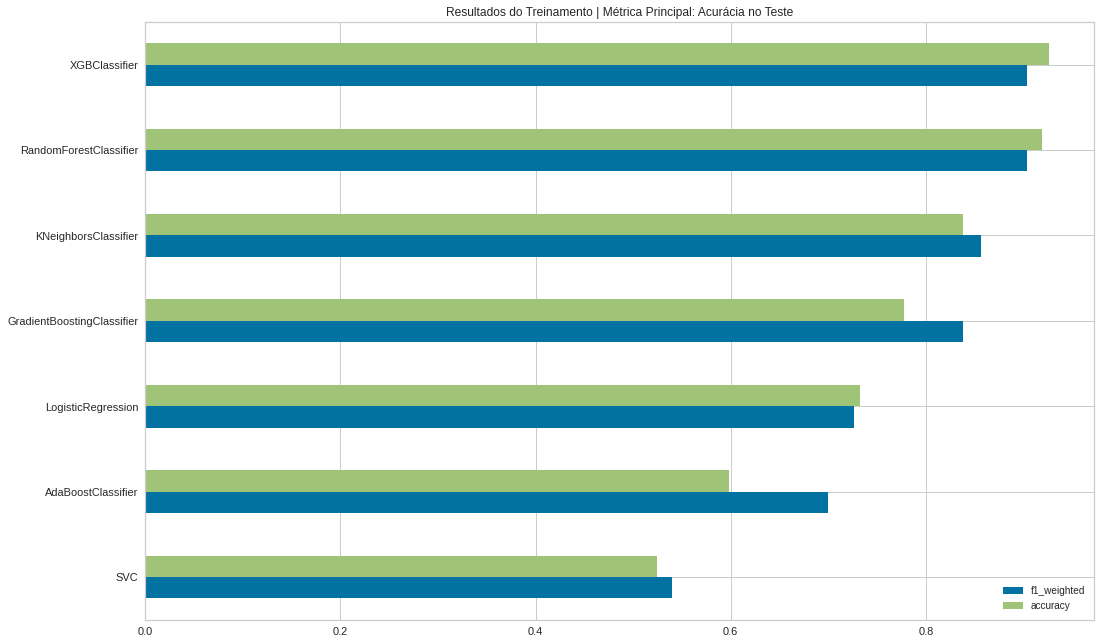

In [ ]:
fig = dfResultados.sort_values(by=['accuracy', gridsearchcv_scoring]).plot(title='Resultados do Treinamento | Métrica Principal: Acurácia no Teste', kind='barh', figsize=(17, 11), fontsize=11).get_figure()
fig.savefig('resultados.png')

In [ ]:
arquivo_resultados_caminho = configuracao_global['ARQUIVO']['dir_treinamento'] + configuracao_global['ARQUIVO']['arquivo_resultados']

with open(arquivo_resultados_caminho, 'w', encoding='utf8') as arquivo:
  json.dump(resultados, arquivo, ensure_ascii=False, sort_keys=True, indent=4)

Considerando a Acurácia e o parâmetro para o Grid Search "*scoring*", definido o melhor modelo ajustado. Ou seja, aquele que obtiver o valor maior, é eleito o melhor classificador. Esse melhor modelo é copiado para a pasta raiz do projeto para ser utilizado em predições futuras.

In [ ]:
melhor_modelo = dfResultados.sort_values(by=['accuracy', gridsearchcv_scoring], ascending=False).first_valid_index()
melhor_modelo

'XGBClassifier'

In [ ]:
copyfile(configuracao_global['ARQUIVO']['dir_treinamento'] + melhor_modelo + '.joblib', 'modelo.joblib')

'modelo.joblib'

In [ ]:
modelo = load('modelo.joblib')

In [ ]:
dict(modelo.best_estimator_.steps)['estimador']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

Análise da Curva de Aprendizado do melhor modelo que mostra como os erros de treino e generalização evoluem conforme utilizamos mais dados de treinamento.



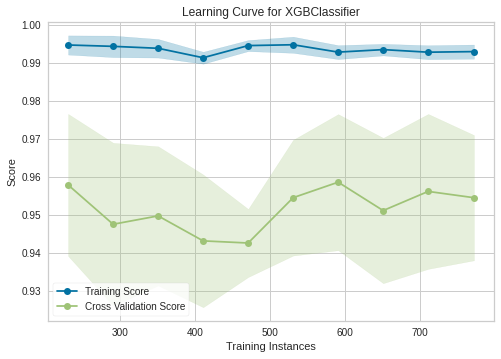

In [ ]:
cv = StratifiedKFold(n_splits=gridsearchcv_cv)
sizes = np.linspace(0.3, 1.0, 10)

model = dict(modelo.best_estimator_.steps)['estimador']

viz = LearningCurve(model, cv=cv, scoring=gridsearchcv_scoring, train_sizes=sizes, n_jobs=4)

viz.fit(X, y)
viz.poof()

Predição da base de teste utilizando o melhor modelo como exemplo de utilização deste modelo no mundo real se publicado em produção e recebendo as respostas do questionário sócio-comportamental e de saúde de pacientes.

In [ ]:
pred = modelo.predict(X_test)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Nesta predição de exemplo, das 284 pacientes, 1% teriam o resultado da biópsia positivo considerado uma margem de 92,6% de confiabilidade.

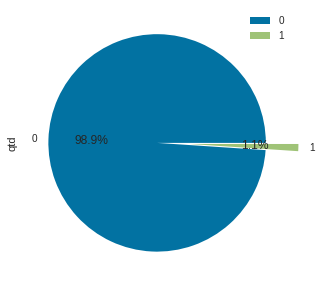

In [ ]:
pred_dict = dict(Counter(pred))
pd.DataFrame(pred_dict.values(), index=pred_dict.keys(), columns=['qtd']).plot.pie(y='qtd', figsize=(5, 5), autopct='%1.1f%%', explode=(0, 0.3))